In [7]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from matplotlib import colors
import os

In [8]:
kBT    = 10
beta   = 1./kBT
kBT_   = 20
beta_  = 1./kBT_
n      = 10
sigma  = 0.05
aa     = np.array([-0.558223634633, 1.4417258418],dtype=np.float64)
bb     = np.array([0.623499404931, 0.0280377585287],dtype=np.float64)

def V(px):
    aa = [-1,-1,-6.5,0.7]
    bb = [0,0,11,0.6]
    cc = [-10,-10,-6.5,0.7]
    AA = [-200,-100,-170,15]
    XX = [1,0,-0.5,-1]
    YY = [0,0.5,1.5,1]
    ee = 0
    for j in range(4):
        ee =  ee + AA[j]*np.exp(aa[j]*(px[:,0]-XX[j])**2+bb[j]*(px[:,0]-XX[j])*(px[:,1]-YY[j])+cc[j]*(px[:,1]-YY[j])**2)
    ee += 9*np.sin(2*5*np.pi*px[:,0])*np.sin(2*5*np.pi*px[:,1])
    for i in range(2,n):
        ee += px[:,i]**2/2/sigma**2
    return ee

def Grad(px):
    aa = [-1,-1,-6.5,0.7]
    bb = [0,0,11,0.6]
    cc = [-10,-10,-6.5,0.7]
    AA = [-200,-100,-170,15]

    XX = [1,0,-0.5,-1]
    YY = [0,0.5,1.5,1]
    
    gg = np.zeros(shape=(n,),dtype=np.float64)
    for j in range(4):
        ee = AA[j]*np.exp(aa[j]*(px[0]-XX[j])**2+bb[j]*(px[0]-XX[j])*(px[1]-YY[j])+cc[j]*(px[1]-YY[j])**2)
        gg[0] = gg[0] + (2*aa[j]*(px[0]-XX[j])+bb[j]*(px[1]-YY[j]))*ee
        gg[1] = gg[1] + (bb[j]*(px[0]-XX[j])+2*cc[j]*(px[1]-YY[j]))*ee
    gg[0] += 9*2*5*np.pi*np.cos(2*5*np.pi*px[0])*np.sin(2*5*np.pi*px[1])
    gg[1] += 9*2*5*np.pi*np.sin(2*5*np.pi*px[0])*np.cos(2*5*np.pi*px[1])
    for i in range(2,n):
        gg[i] = px[i]/sigma**2
    return gg

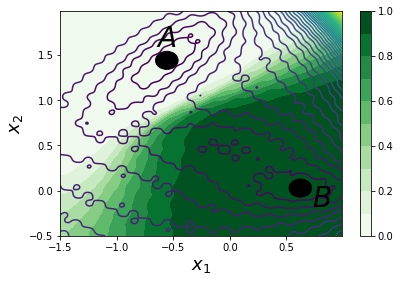

In [9]:
grids = []
xx = np.arange(-1.5, 1.0, 0.01)
yy = np.arange(-0.5, 2.0, 0.01)
XX, YY = np.meshgrid(xx, yy)
sizes = np.shape(XX)
for i in range(sizes[0]):
    for j in range(sizes[1]):
        grids.append([xx[j],yy[i]]+[0]*(n-2))
        
# plot potential contour lines
ZZ=np.reshape(V(np.array(grids)),sizes)
plt.contour(XX, YY, ZZ, 50)

# plot FEM q value
levels=[0.01,0.3,0.5,0.7,0.9,0.99]
qFEM = np.loadtxt("../FEM/"+str(kBT)+".txt")
ZZ = np.reshape(qFEM,sizes)
CS = plt.contourf(XX, YY, ZZ, 10,cmap='Greens')
plt.colorbar(CS)

plt.text(aa[0]-0.1, aa[1]+0.15, '$A$', fontsize=28)
plt.text(bb[0]+0.1, bb[1]-0.2,  '$B$', fontsize=28)
plt.gca().add_patch(plt.Circle(aa, 0.1, color='k'))
plt.gca().add_patch(plt.Circle(bb, 0.1, color='k'))
plt.xlabel('$x_{1}$', fontsize=18)
plt.ylabel('$x_{2}$', fontsize=18)
plt.gca().set_aspect(0.8)
plt.tight_layout()
plt.savefig('Mueller_10_true.eps', format='eps', dpi=1000)
plt.show()

In [10]:
def construct_NN(x,nlayer,nnode):
    q = tf.contrib.layers.fully_connected(x,nnode,tf.nn.tanh,scope ="layer1")
    for i in range(1,nlayer):
        q = tf.contrib.layers.fully_connected(q,nnode,tf.nn.tanh,scope ="layer"+str(i+1))
    q = tf.contrib.layers.fully_connected(q,1,tf.nn.sigmoid,scope="output")
    dA2 = (x[:,0]-aa[0])**2+(x[:,1]-aa[1])**2
    dB2 = (x[:,0]-bb[0])**2+(x[:,1]-bb[1])**2
    IA = 0.5-0.5*tf.nn.tanh( 1000*(dA2-0.1**2)  )
    IB = 0.5-0.5*tf.nn.tanh( 1000*(dB2-0.1**2)  )
    return (1-IA)*(1-IB)*tf.reshape(q,[-1])+(1-IA)*IB

tf.reset_default_graph()

# input
x = tf.placeholder(dtype=tf.float64, shape=[None,n])
coef = tf.placeholder(dtype=tf.float64, shape=[None,])

# q and gradients
q = construct_NN(x,2,20)
g = tf.gradients(q, x)[0]
fn = tf.reduce_mean( tf.reduce_sum(g**2,axis=1)*coef )

# train_step and initialization
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)

INFO:tensorflow:Restoring parameters from ../saved_models/Mueller_10_20_220.ckpt


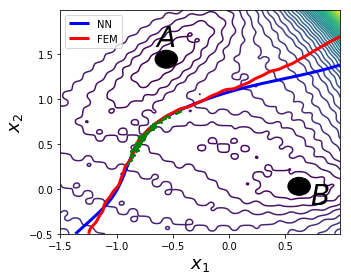

In [13]:
NNfile = "../saved_models/Mueller_"+str(kBT)+"_"+str(kBT_)+"_220.ckpt"
saver.restore(sess,NNfile)

# potential contour
ZZ=np.reshape(V(np.array(grids)),sizes)
plt.contour(XX, YY, ZZ, 50)

# sampled tansition states
cs = np.loadtxt('../FEM/coor_220.txt')
plt.plot(cs[:,0],cs[:,1],'.',color='green',markersize=4)

# 1/2 isosurfaces
levels = [0.5]
ZZ=np.reshape(sess.run(q,{x:grids}),sizes)
CS1 = plt.contour(XX, YY, ZZ, levels,colors='blue',linewidths=3)
qFEM = np.loadtxt("../FEM/"+str(kBT)+".txt")
ZZ = np.reshape(qFEM,sizes)
CS2 = plt.contour(XX, YY, ZZ, levels,colors='red',linewidths=3)

# legend
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
plt.legend([h1[0], h2[0]],['NN','FEM'],loc="upper left")

# plot A and B
plt.gca().add_patch(plt.Circle(aa, 0.1, color='k'))
plt.gca().add_patch(plt.Circle(bb, 0.1, color='k'))
plt.text(aa[0]-0.1, aa[1]+0.15, '$A$', fontsize=28)
plt.text(bb[0]+0.1, bb[1]-0.2,  '$B$', fontsize=28)

plt.xlabel('$x_{1}$', fontsize=18)
plt.ylabel('$x_{2}$', fontsize=18)
plt.gca().set_aspect(0.8)
plt.tight_layout()
plt.savefig('Mueller_10_220_iso.eps', format='eps', dpi=1000)
plt.show()